# Arp Peculiar Galaxy (Northern) Observing Program

Astronomical League Arp Peculiar Galaxy (Northern) Observing Program  
https://www.astroleague.org/arp-peculiar-galaxy-northern-observing-program/

Atlas of Peculiar Galaxies (Google Drive)  
https://drive.google.com/file/d/1JgIL71wtXLzui6TGsMWVjRdQGamIlbDK/view?usp=sharing

Atlas of Peculiar Galaxies (original at ADS)  
Arp, Halton: Astrophysical Journal Supplement, vol. 14, p.1 (1966) 14, 1 (1966)  
https://ui.adsabs.harvard.edu/abs/1966ApJS...14....1A/abstract

Atlas of Peculiar Galaxies (NASA/IPAC at Caltech)  
https://ned.ipac.caltech.edu/level5/Arp/frames.html

General imports

In [1]:
import os
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import Angle, Longitude, Latitude, SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_rgb
from astropy.wcs import WCS

from astroquery.hips2fits import hips2fits
from astroquery.vizier import Vizier

from ipyaladin import Aladin

In [2]:
hips2fits.timeout = 40  # default is 30 seconds, but some queries take longer

## Vizier with astroquery

 Arp's Peculiar Galaxies : VII/192 at Strasbourg Astronomical Data Center &nbsp; [![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

In [3]:
vizier = Vizier(row_limit=-1) # Default row limit is 50. -1 means no limit.

catalog_list = vizier.find_catalogs('Arp Peculiar Galaxies')
for k, v in catalog_list.items():
    print(k, ":", v.description)

VII/74A : Atlas of Peculiar Galaxies (Arp 1966)
VII/192 : Arp's Peculiar Galaxies (Webb 1996)


`VII/192` contains two tables:

- `VII/192/arplist`: the list of Arp views with imaging data.
- `VII/192/arpord`: list and info for the involved galaxies

In [4]:
arpord, arplist = vizier.get_catalogs('VII/192')

arpord.remove_columns(['fl_245', 'fl_ST6', 'fl_ST5', 'APG', 'Simbad', 'NED'])
arplist.remove_columns(['Simbad', 'NED'])

In [5]:
# index the tables by Arp number
arpord.add_index('Arp')
arplist.add_index('Arp')

In [6]:
# correct the Declination for Arp 118
arpord.loc[118]['DEJ2000'] = '-00 10.7'

arpord.loc[118]

Arp,Name,RAJ2000,DEJ2000,Size,Orient
,,,,arcmin,
int16,str17,str8,str8,float32,str1
118,NGC 1144 + 43,02 55 11,-00 10.7,2.1,E


In [7]:
arplist.loc[118]

Arp,Name,VT,u_VT,dim1,dim2,u_dim2,MType,Uchart,RAJ2000,DEJ2000
,,mag,,arcmin,arcmin,,,,,
int16,str16,float32,str1,float32,float32,str1,str14,int16,str10,str9
118,NGC 1143,13.2,,--,--,,SAB0-:pec/Rng,220,02 55 09.7,-00 10 40
118,NGC 1144,12.9,,--,--,,Im pec/Ring B,220,02 55 11.1,-00 10 37


Intitialize an Aladin Lite viewer

In [8]:
options = {"show_projection_control": False, "show_fullscreen_control": False, "height":600}
aladin = Aladin(**options); aladin

Aladin()

Display the Arp view by number in Aladin Lite.

In [9]:
def get_fov(size):
    if size >= 60:
        fov = 72
    elif size >= 30:
        fov = 60
    elif size >= 20:
        fov = 48
    elif size >= 15:
        fov = 36
    else:
        fov = 24

    return Angle(fov, u.arcmin)

In [10]:
arp_number = 153
aladin.target = SkyCoord(*arpord.loc[arp_number]['RAJ2000', 'DEJ2000'], unit=(u.hourangle, u.deg))
aladin.fov = get_fov(arpord.loc[arp_number]['Size'])

In [13]:
def hips_cutout(arp, ra, dec, size, hips='CDS/P/DSS2/color'):
    """
    Create a FITS file from a HiPS cutout.
    """
    survey = hips.split('/')
    filename = f'finder_charts/Arp_{arp}_{survey[2]}_{survey[3]}.fits'
    if os.path.exists(filename):
        print(f"fits file for Arp {arp} already exists.")
        return
    fov = get_fov(size)
    
    result = hips2fits.query(
        hips=hips,
        width=2160,
        height=2160,
        ra=Longitude(ra, unit=u.hourangle),
        dec=Latitude(dec, unit=u.deg),
        fov=fov,
        projection="TAN",
        get_query_payload=False,
        format='fits'
    )
    
    result.writeto(filename)
    return filename

In [14]:
def make_chart(arp, ra, dec, size, hips='CDS/P/DSS2/color'):
    """
    Create a finder chart for the given Arp number.
    """
    survey = hips.split('/')
    filename = f'finder_charts/Arp_{arp}_{survey[2]}_{survey[3]}.fits'
    hips_cutout(arp, ra, dec, size, hips=hips)
    
    with fits.open(filename) as hdul:
        hdu = hdul[0]
        r, g, b = hdu.data[0:3]
        wcs = WCS(hdu.header)[0]
        fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=wcs))
        rgb_image = make_rgb(r, g, b)
        ax.imshow(rgb_image)
        ax.grid(alpha=.5)
        ax.set(xlabel='RA[hms]', ylabel='Dec[dms]')
        ax.set_title(f'Arp {arp} ({arpord.loc[arp]["Name"]})')
        # fig.tight_layout(pad=0.1)
        fig.savefig(f'{filename.split('.')[0]}.pdf')


fits file for Arp 153 already exists.


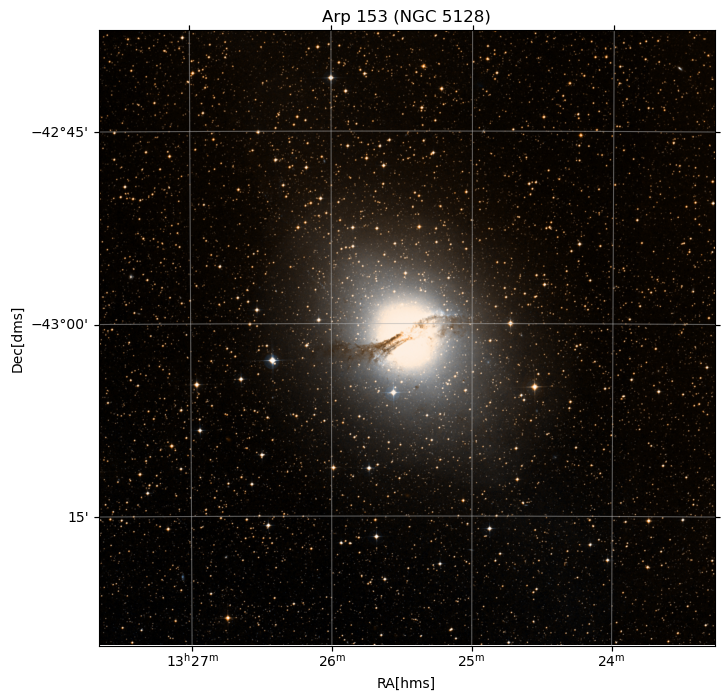

In [15]:
ra = arpord.loc[arp_number]['RAJ2000']
dec = arpord.loc[arp_number]['DEJ2000']
size = arpord.loc[arp_number]['Size']

make_chart(arp_number, ra, dec, size)

Search the atlas by constellation.

In [16]:
# add a column for the constellation
arpord['Const'] = SkyCoord(arpord['RAJ2000'], arpord['DEJ2000'],
         unit=(u.hourangle, u.deg)).get_constellation()

arplist['Const'] = SkyCoord(arplist['RAJ2000'], arplist['DEJ2000'],
         unit=(u.hourangle, u.deg)).get_constellation()

In [17]:
arpord[arpord['Const'] == 'Boötes']

Arp,Name,RAJ2000,DEJ2000,Size,Orient,Const
,,,,arcmin,,
int16,str17,str8,str8,float32,str1,str19
42,NGC 5829+IC4526,15 02 42,+23 19.9,3.5,N,Boötes
45,UGC 09178,14 19 51,+51 54.3,2.6,E,Boötes
47,CGCG 105-026,14 47 13,+18 51.5,2.6,N,Boötes
49,NGC 5665,14 32 26,+08 04.8,2.6,E,Boötes
64,UGC 09503,14 45 26,+19 27.9,2.6,W,Boötes
69,NGC 5579 + 80,14 20 26,+35 11.3,2.6,S,Boötes
79,NGC 5490C,14 10 07,+17 36.9,2.1,E,Boötes
90,NGC 5930 + 29,15 26 08,+41 40.5,2.6,S,Boötes


In [18]:
arpord[arpord['Const'] == 'Draco']

Arp,Name,RAJ2000,DEJ2000,Size,Orient,Const
,,,,arcmin,,
int16,str17,str8,str8,float32,str1,str19
30,NGC 6365A + B,17 22 43,+62 10.4,2.6,N,Draco
32,UGC 10770,17 13 08,+59 19.4,2.1,N,Draco
38,NGC 6412,17 29 36,+75 42.3,3.5,N,Draco
66,UGC 10396,16 26 53,+51 33.3,2.6,N,Draco
81,NGC 6621 + 22,18 12 55,+68 21.8,2.6,S,Draco
109,UGC 10053,15 48 08,+69 27.5,3.5,E,Draco
124,NGC 6361,17 18 41,+60 36.4,3.5,E,Draco
156,UGC 05814,10 42 38,+77 29.7,2.6,E,Draco


In [19]:
arplist[arplist['Const'] == 'Ursa Minor']

Arp,Name,VT,u_VT,dim1,dim2,u_dim2,MType,Uchart,RAJ2000,DEJ2000,Const
,,mag,,arcmin,arcmin,,,,,,
int16,str16,float32,str1,float32,float32,str1,str14,int16,str10,str9,str19
185,NGC 6217,11.2,,3.0,2.5,,(R)SB(rs)bc,11,16 32 40.0,+78 11 57,Ursa Minor
